In [38]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.fft import fft, ifft, fftfreq

import time as time
import platform as platform

In [40]:
colab_flag = True

In [41]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [42]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
print(os.getcwd())

/content/drive/MyDrive/Github/MLROM/KS


In [44]:
from tools.misc_tools import create_KS_data

In [45]:
# setting seed for PRNGs
prng_seed = 42
np.random.seed(prng_seed)

# KS System

In [46]:
# setting up params (and saving, if applicable)
from numpy import *

# simutlation paramaters
params_mat = np.array([
    [1.0, 1.0, 1.0],
    # [2.0, 1.0, 1.0],
    # [1.0, 2.0, 1.0],
    # [1.0, 1.0, 2.0]
])

t0 = 0.0
T = 270.0
delta_t = 0.1

return_params_arr = False
normalize_flag = False
alldata_withparams_flag = False

numpoints_xgrid = 64
length = 40
xgrid = length*np.linspace(0, 1, numpoints_xgrid)

init_state = np.sin(5*np.pi*xgrid/xgrid[-1])

In [47]:
res_dict = create_KS_data(
    T, t0, delta_t, xgrid,
    init_state, params_mat,
    return_params_arr=return_params_arr,
    normalize=normalize_flag,
    alldata_withparams=alldata_withparams_flag,
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']
params_arr = res_dict['params_arr']
normalization_constant_arr = res_dict['normalization_constant_arr']

In [48]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

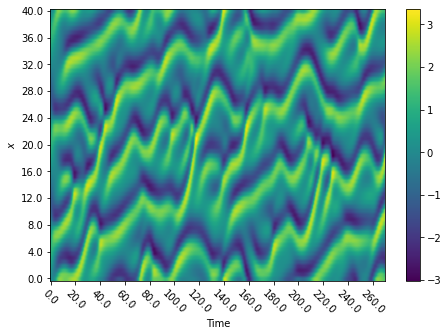

In [49]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

In [50]:
# making relevant helper arrays to cut off initial transient
num_cases = boundary_idx_arr.shape[0]

initial_t0 = np.array([
    20,
    # 20,
    # 20,
    # 20
])
initial_idx = np.zeros_like(initial_t0)

begin_idx = 0
len_relevant_idx = 0
for i in range(num_cases):
    init_idx = (initial_t0[i] + 0.5*delta_t)//delta_t
    initial_idx[i] = init_idx + begin_idx
    len_relevant_idx += boundary_idx_arr[i] - initial_idx[i]
    begin_idx = boundary_idx_arr[i]

relevant_idx = np.empty(shape=len_relevant_idx, dtype=np.int32)
start = 0
for i in range(num_cases):
    end = start + (boundary_idx_arr[i] - initial_idx[i])
    relevant_idx[start:end] = np.arange(initial_idx[i], boundary_idx_arr[i])
    start = end

In [51]:
# cutting off initial transient
all_data = all_data[relevant_idx]
# init_idx = 0
# for i in range(num_cases):
#     init_idx += (initial_t0[i] + 0.25*delta_t)//delta_t
#     boundary_idx_arr[i] -= init_idx

prev_boundary_idx = 0
for i in range(num_cases):
    boundary_idx_arr[i] = prev_boundary_idx + (boundary_idx_arr[i] - initial_idx[i])
    prev_boundary_idx = boundary_idx_arr[i]

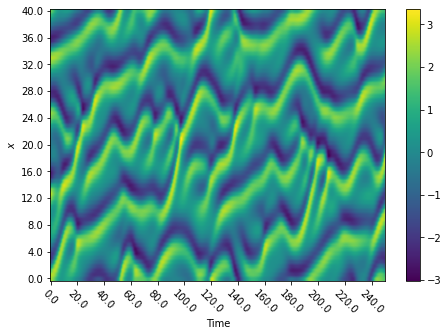

In [52]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

In [53]:
num_passes = 30

new_initial_states = np.empty(shape=(num_cases, num_passes, xgrid.shape[0]))


begin_idx_arr = np.empty(shape=(num_cases, num_passes), dtype=np.int32)
prev_idx = 0
for i in range(num_cases):
    next_idx = boundary_idx_arr[i]
    total_num_points = next_idx - prev_idx - 1
    for j in range(num_passes):
        jth_idx = int(total_num_points*j/(num_passes-1))
        # new_initial_states[i, j, :] = all_data[prev_idx + jth_idx, :]
        begin_idx_arr[i, j] = jth_idx
    prev_idx = next_idx

lp_exp : 0.09472304184552766


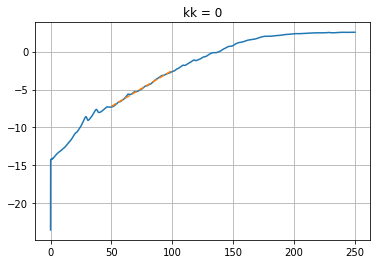


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


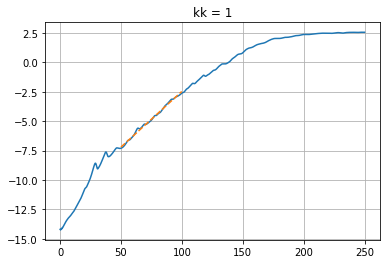

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


lp_exp : 0.09472304184552766


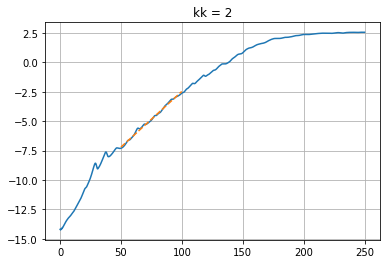


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


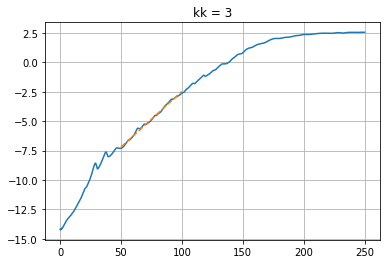


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


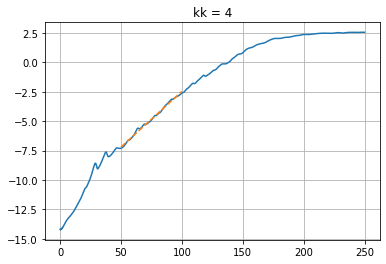


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


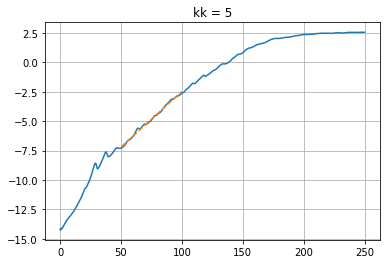


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


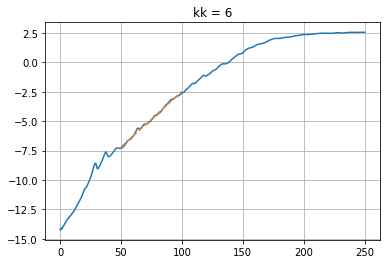


lp_exp : 0.09472304184552766


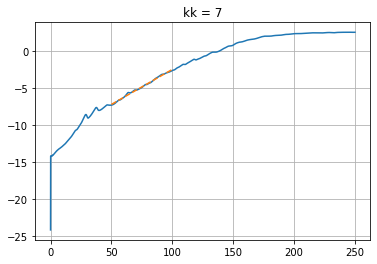


lp_exp : 0.09472304184552766


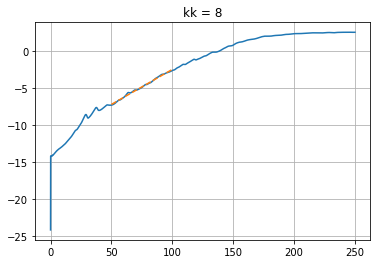


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


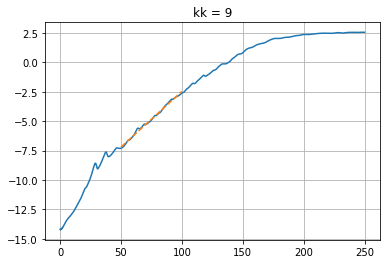


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


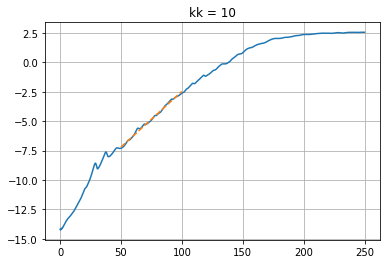


lp_exp : 0.09472304184552766


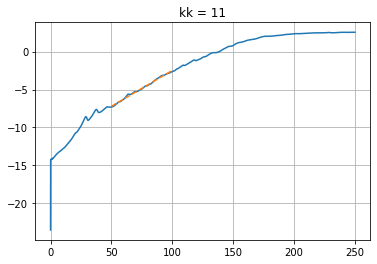


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


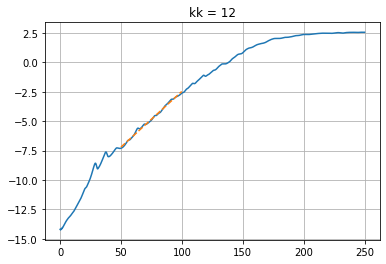


lp_exp : 0.09472304184552766


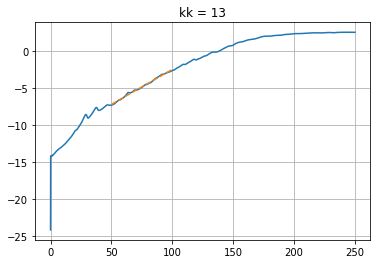


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


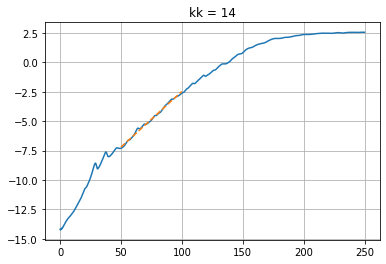


lp_exp : 0.09472304184552766


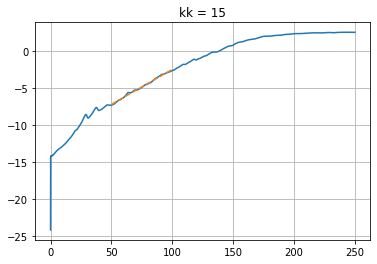


lp_exp : 0.09472304184552766


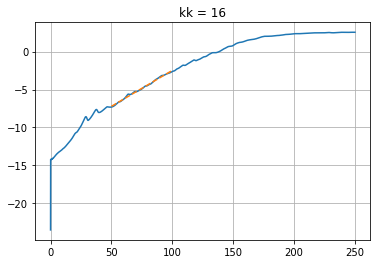


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


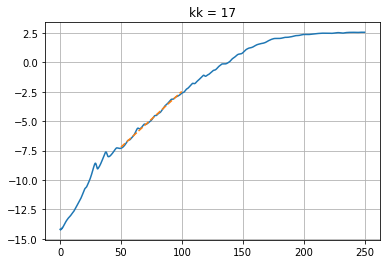


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


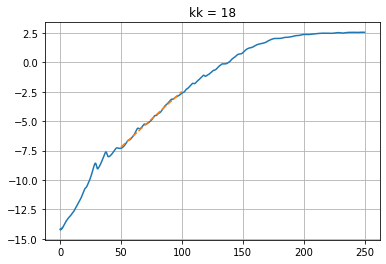


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


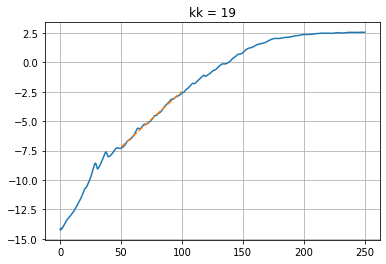


lp_exp : 0.09472304184552766


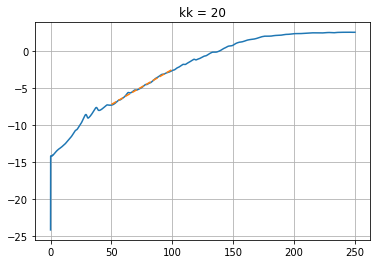


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


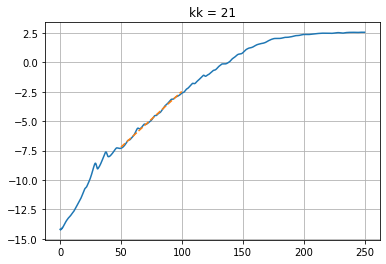


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


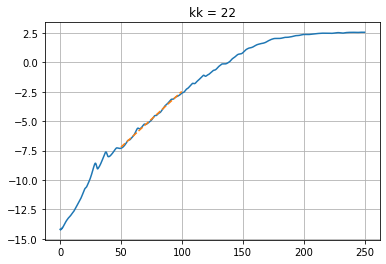


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


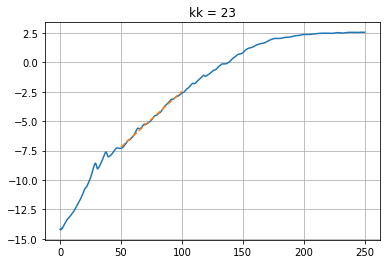


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


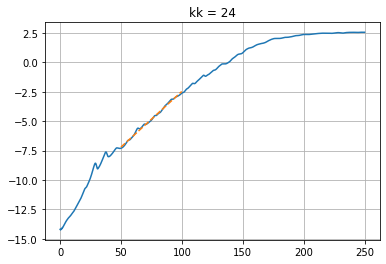


lp_exp : 0.09472304184552766


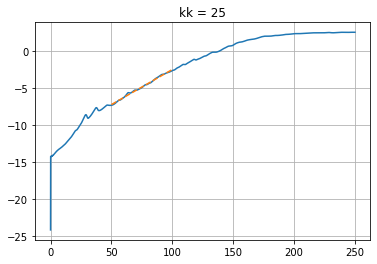


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


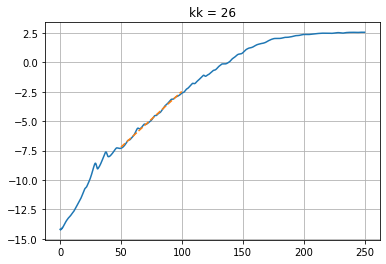


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


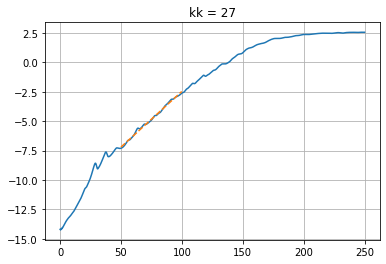


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


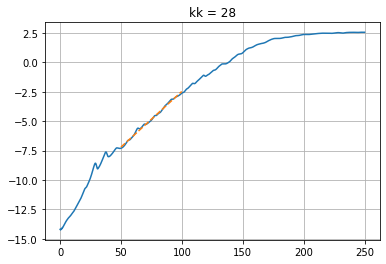


lp_exp : 0.09472304184552766


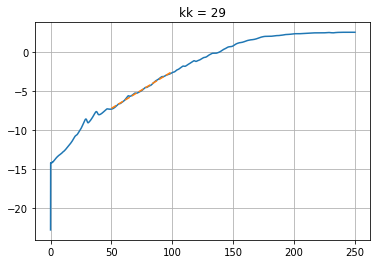


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


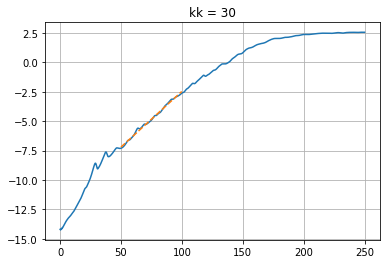


lp_exp : 0.09472304184552766


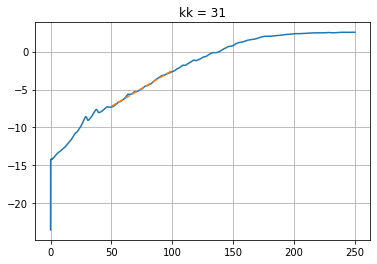


lp_exp : 0.09472304184552766


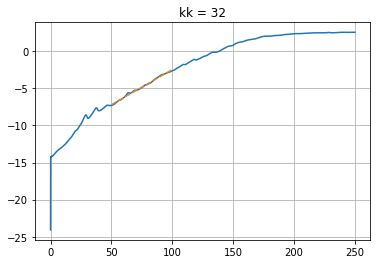


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


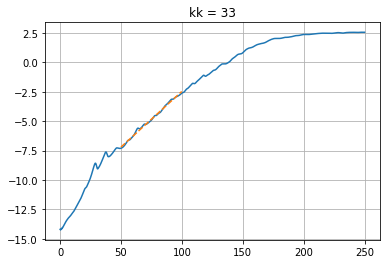

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


lp_exp : 0.09472304184552766


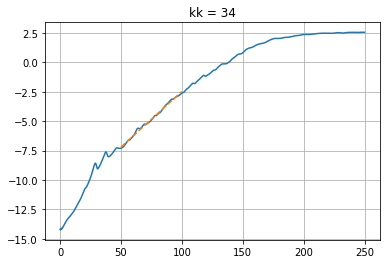


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


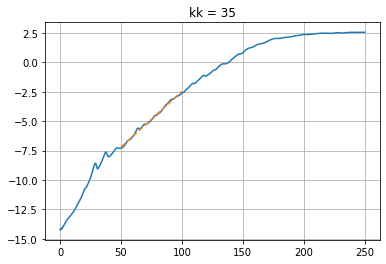


lp_exp : 0.09472304184552766


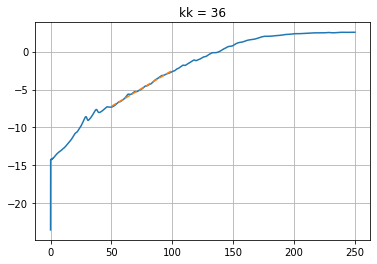


lp_exp : 0.09472304184552766


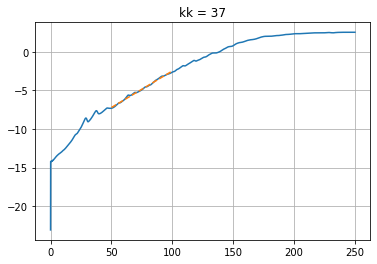


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


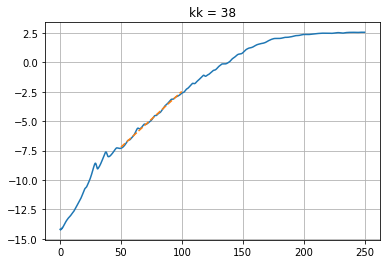


lp_exp : 0.09472304184552766


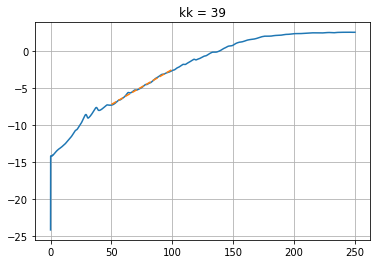


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


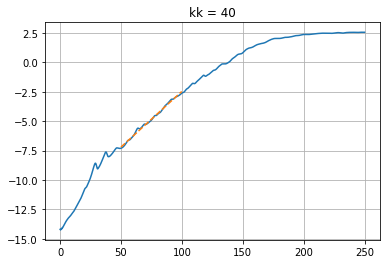


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


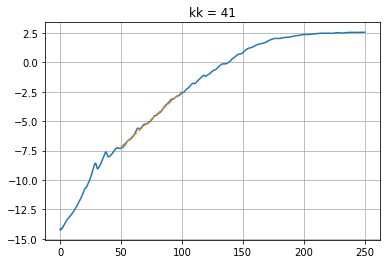


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


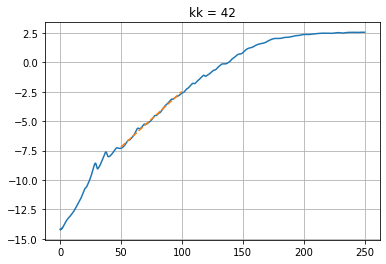


lp_exp : 0.09472304184552766


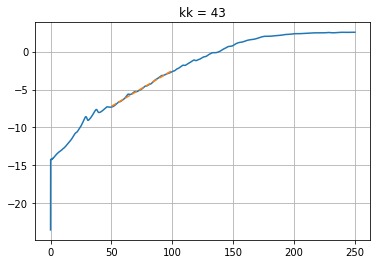


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


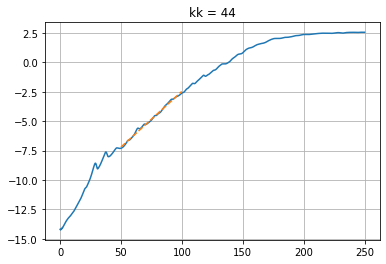


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


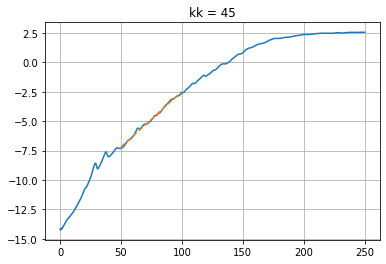


lp_exp : 0.09472304184552766


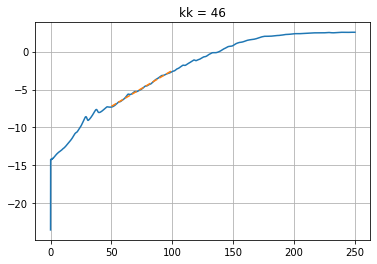


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


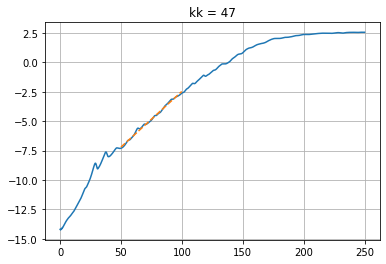


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


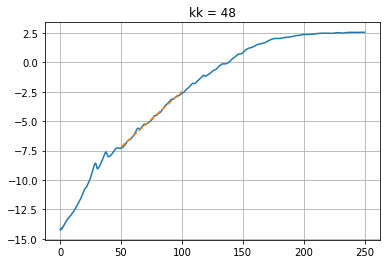


lp_exp : 0.09472304184552766


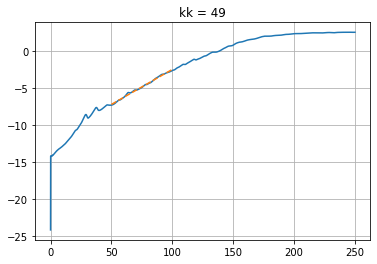


lp_exp : 0.09472304184552766


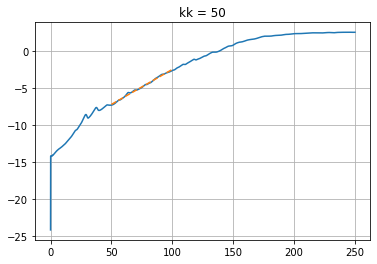


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


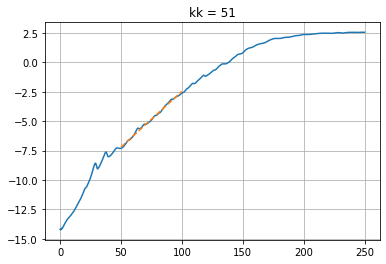


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


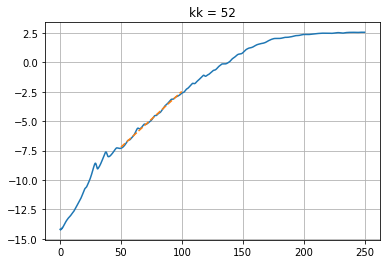


lp_exp : 0.09472304184552766


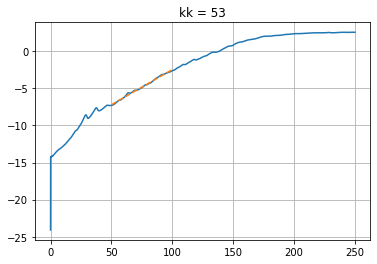


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


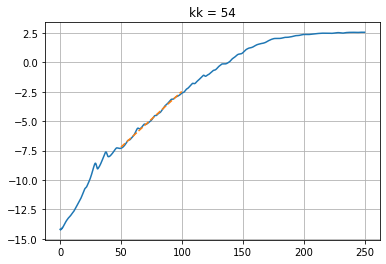


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


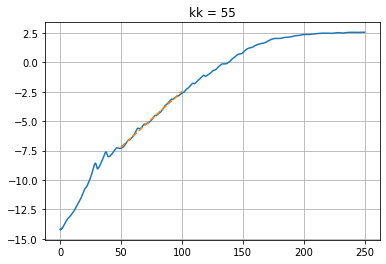


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


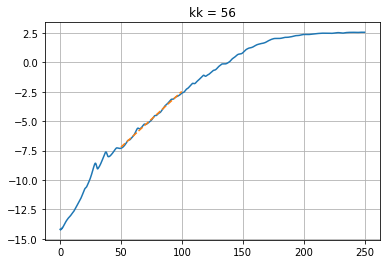


lp_exp : 0.09472304184552766


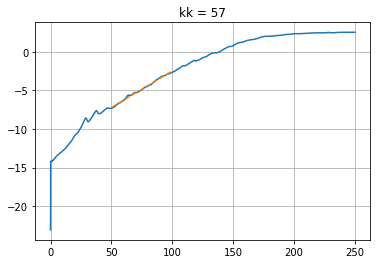


lp_exp : 0.09472304184552766


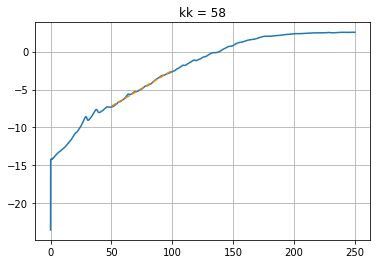


lp_exp : 0.09472304184552766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


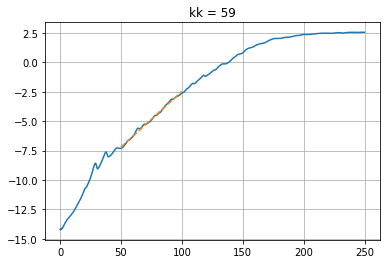


lp_exp : 0.09472304184552766


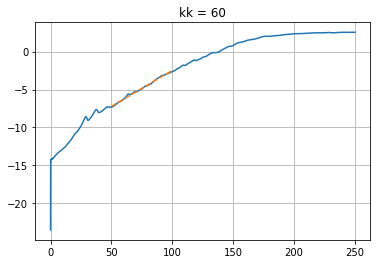


lp_exp : 0.09472304184552766


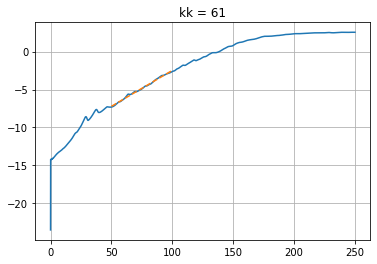


lp_exp : 0.09472304184552766


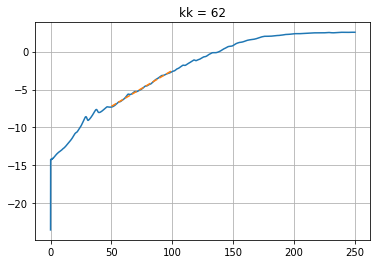


lp_exp : 0.09472304184552766


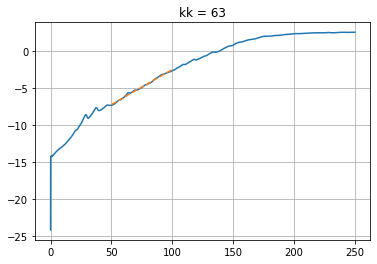

In [55]:
dy = 1e-9
tbegin_lexp = 50
tend_lexp = 100

idxbegin_lexp = int((tbegin_lexp+0.5*delta_t)//delta_t)
idxend_lexp = int((tend_lexp+0.5*delta_t)//delta_t)

lp_spectrum_mat = np.empty(shape=(num_cases, xgrid.shape[0]))

case_prev_idx = 0
for ii in range(num_cases):
    total_num_points = int((T-initial_t0[ii] + 0.5*delta_t)//delta_t)
    # init_state = new_initial_states[ii, 0, :]
    init_state = all_data[case_prev_idx + begin_idx_arr[ii, 0]].copy()
    total_time = 2*(T-initial_t0[ii])
    res_dict = create_KS_data(
        total_time, 0, delta_t, xgrid,
        init_state, params_mat[ii],
        return_params_arr=False,
        normalize=False,
        alldata_withparams=False,
    )
    all_data = res_dict['all_data']
    for kk in range(xgrid.shape[0]):
    # for kk in range(1):
        for jj in range(num_passes):
            # init_state_ydy = new_initial_states[ii, jj, :]
            init_state_ydy = all_data[case_prev_idx + begin_idx_arr[ii, jj]].copy()
            init_state_ydy[kk] += dy
            res_dict_ydy = create_KS_data(
                T-initial_t0[ii], 0, delta_t, xgrid,
                init_state_ydy, params_mat[ii],
                return_params_arr=False,
                normalize=False,
                alldata_withparams=False,
            )
            ydy = res_dict_ydy['all_data']
            all_data_begin_idx = begin_idx_arr[ii, jj]
            ydy_all_data_diff = ydy - all_data[all_data_begin_idx:all_data_begin_idx+ydy.shape[0]]
            if jj == 0:
                reduce_lst = np.linalg.norm(ydy_all_data_diff, axis=1)
            else:
                len_ydy = ydy.shape[0]
                len_reducelst = len(reduce_lst)
                if len_reducelst <= len_ydy:
                    reduce_lst += np.linalg.norm(ydy_all_data_diff, axis=1)[0:len_reducelst]
                else:
                    reduce_lst = reduce_lst[0:len_ydy]
                    reduce_lst += np.linalg.norm(ydy_all_data_diff, axis=1)[0:len_reducelst]
            # plt.plot(np.arange(ydy.shape[0])*delta_t, np.log( np.linalg.norm(ydy_all_data_diff, axis=1)/dy ))
            # plt.grid(True)
            # plt.show()
            # print('')
        reduce_lst /= num_passes
        ln_reduce_lst = np.log(reduce_lst)
        time_plot_arr = np.arange(reduce_lst.shape[0])*delta_t
        lp_exp_coeffs = np.polyfit(time_plot_arr[idxbegin_lexp:idxend_lexp+1], ln_reduce_lst[idxbegin_lexp:idxend_lexp+1], deg=1)
        lp_exp = lp_exp_coeffs[0]
        lp_spectrum_mat[ii, kk] = lp_exp

        print('lp_exp :', lp_exp)
        plt.plot(time_plot_arr, ln_reduce_lst)
        lpexp_time_arr = np.arange(idxbegin_lexp, idxend_lexp)*delta_t
        lpexp_bestfitline = lp_exp_coeffs[0]*lpexp_time_arr + lp_exp_coeffs[1]
        plt.plot(lpexp_time_arr, lpexp_bestfitline, '--')
        plt.grid(True)
        plt.title('kk = {}'.format(kk))
        plt.show()
        print('')

    case_prev_idx = boundary_idx_arr[ii]

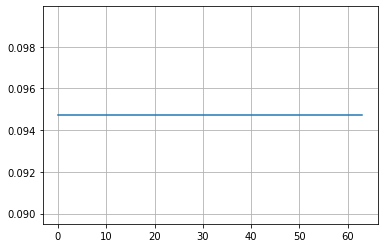

In [56]:
plt.plot(lp_spectrum_mat[0])
plt.grid(True)
plt.show()

In [57]:
lp_spectrum_mat.max()

0.09472304184552766

In [58]:
lp_spectrum_mat.sort()

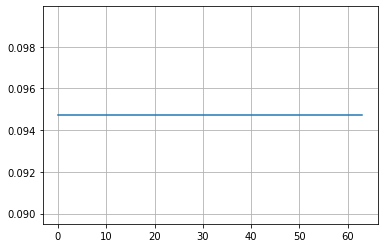

In [59]:
plt.plot(lp_spectrum_mat[0])
plt.grid(True)
plt.show()